# Week 4 - Function 8 ((43DP, 8D))

# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats.qmc import LatinHypercube
from ipywidgets import interact, FloatSlider

from utils.plotting_utils import (
    plot_8D_shap_analysis,
    plot_output_outliers,
    plot_nd_mean_uncertainty_slice
)

# Plan
We now have ((43, 8)) - 43DP & 8D that can be found `./data/week_4/function_8/`.

1. Load data
2. Preprocessing (StandardScaler — no outliers)
3. Build probabilistic Model (GP with ARD, identify noise dims)
4. Feature selection (drop noise dims)
5. Interactive GP visualization (2D slices)
6. Acquisition Function (UCB on LHS candidates in effective space)

# 1. Load data

In [2]:
X_train_raw = np.load(r"./data/week_4/function_8/inputs.npy")
y_train_raw = np.load(r"./data/week_4/function_8/outputs.npy")
print(f"Shape: X={X_train_raw.shape}, y={y_train_raw.shape}")
print(f"X range: [{X_train_raw.min():.4f}, {X_train_raw.max():.4f}]")
print(f"y range: [{y_train_raw.min():.2e}, {y_train_raw.max():.2e}]")

Shape: X=(43, 8), y=(43,)
X range: [0.0034, 0.9989]
y range: [5.59e+00, 9.60e+00]


/opt/anaconda3/lib/python3.13/site-packages/shap/plots/_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


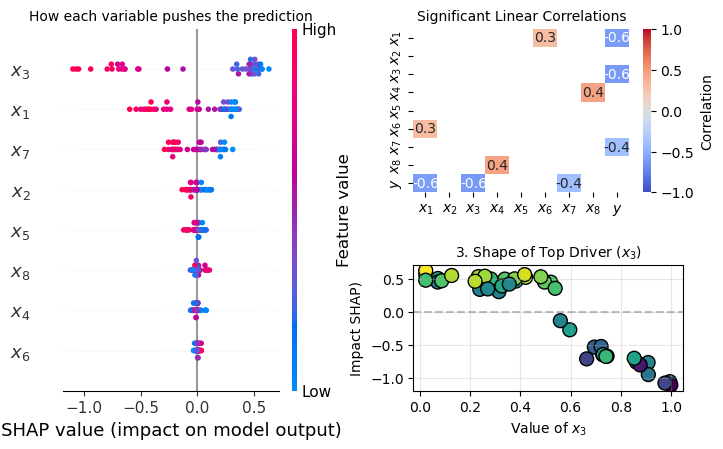

In [3]:
plot_8D_shap_analysis(X_train_raw, y_train_raw)

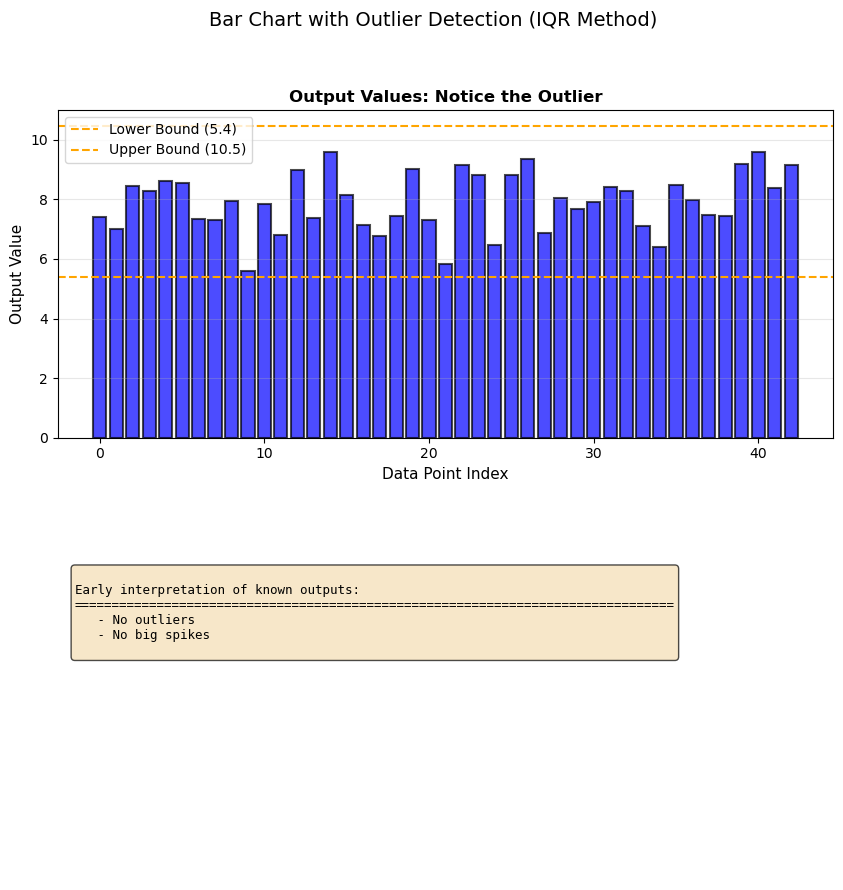

In [4]:
plot_output_outliers(X_train_raw, y_train_raw, "Bar Chart with Outlier Detection (IQR Method)", f"""
Early interpretation of known outputs:
{'='*80}
   - No outliers
   - No big spikes
""")

# 2. Preprocessing

No outliers, so StandardScaler is appropriate.

In [5]:
scaler_X = MinMaxScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train_raw)
y_train = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).ravel()

print(f"Total points: {len(X_train)}")
print(f"Scaled y range: [{y_train.min():.2f}, {y_train.max():.2f}]")

Total points: 43
Scaled y range: [-2.37, 1.74]


# 3. GP with ARD (full 8D) — identify noise dimensions

We first fit on all 8 dims. Dimensions with very large length scales (> 1e6) are noise and can be dropped.

In [6]:
kernel_full = ConstantKernel(1.0, (1e-3, 1e3)) * Matern(
    length_scale=[0.5]*8, nu=2.5,
    length_scale_bounds=(1e-3, 1e12)
)

model_full = GaussianProcessRegressor(
    kernel=kernel_full,
    alpha=0.01,
    normalize_y=True,
    n_restarts_optimizer=30
)

model_full.fit(X_train, y_train)
print(f"Full 8D Kernel: {model_full.kernel_}")

learned_scales = model_full.kernel_.k2.length_scale
importance = 1.0 / learned_scales
importance_norm = importance / importance.sum() * 100

print(f"\nFeature Importance (from ARD length scales):")
print(f"{'Dim':<6} {'Length Scale':<20} {'Importance %':<15} {'Role'}")
print("=" * 80)
noise_threshold = 1e4
noise_dims = []
active_dims = []
sorted_dims = np.argsort(learned_scales)
for i in sorted_dims:
    if learned_scales[i] > noise_threshold:
        role = 'NOISE (drop)'
        noise_dims.append(i)
    elif learned_scales[i] > 10.0:
        role = 'weak'
        active_dims.append(i)
    else:
        role = 'IMPORTANT'
        active_dims.append(i)
    print(f"x{i+1:<5} {learned_scales[i]:<20.4f} {importance_norm[i]:<15.4f} {role}")

print(f"\nNoise dims (length scale > {noise_threshold:.0e}): {['x'+str(d+1) for d in noise_dims]}")
print(f"Active dims: {['x'+str(d+1) for d in active_dims]}")

Full 8D Kernel: 4.29**2 * Matern(length_scale=[3.03, 4.22, 2.25, 10.7, 14.4, 5.87e+05, 3.23, 7.24e+05], nu=2.5)

Feature Importance (from ARD length scales):
Dim    Length Scale         Importance %    Role
x3     2.2505               29.9552         IMPORTANT
x1     3.0339               22.2198         IMPORTANT
x7     3.2299               20.8715         IMPORTANT
x2     4.2189               15.9789         IMPORTANT
x4     10.7157              6.2911          weak
x5     14.3947              4.6832          weak
x6     587459.3219          0.0001          NOISE (drop)
x8     724336.9240          0.0001          NOISE (drop)

Noise dims (length scale > 1e+04): ['x6', 'x8']
Active dims: ['x3', 'x1', 'x7', 'x2', 'x4', 'x5']


# 4. Feature selection — refit GP on active dims only

Drop noise dimensions and refit. This reduces the effective dimensionality and improves GP predictions.

In [7]:
n_active = len(active_dims)
X_train_active = X_train[:, active_dims]
print(f"Effective dimensionality: {n_active}D (dropped {len(noise_dims)} noise dims)")

kernel_active = ConstantKernel(1.0, (1e-3, 1e3)) * Matern(
    length_scale=[0.5]*n_active, nu=2.5,
    length_scale_bounds=(1e-3, 1e2)
)

model = GaussianProcessRegressor(
    kernel=kernel_active,
    alpha=0.01,
    normalize_y=True,
    n_restarts_optimizer=30
)

model.fit(X_train_active, y_train)
print(f"Active-dim kernel: {model.kernel_}")

# Feature importance within active dims
ls_active = model.kernel_.k2.length_scale
imp_active = 1.0 / ls_active
imp_active_norm = imp_active / imp_active.sum() * 100

print(f"\nActive dim importance:")
sorted_active = np.argsort(ls_active)
for j in sorted_active:
    orig_dim = active_dims[j]
    print(f"  x{orig_dim+1}: ls={ls_active[j]:.4f}, importance={imp_active_norm[j]:.1f}%")

# Determine plot/slider dims (within active space)
most_important_active = sorted_active[:2]
slider_active = sorted_active[2:]
dim_a_orig = active_dims[most_important_active[0]]
dim_b_orig = active_dims[most_important_active[1]]
slider_dims_orig = [active_dims[j] for j in slider_active]
print(f"\nPlotting dims: x{dim_a_orig+1}, x{dim_b_orig+1}")
print(f"Slider dims: {['x'+str(d+1) for d in slider_dims_orig]}")

Effective dimensionality: 6D (dropped 2 noise dims)
Active-dim kernel: 4.56**2 * Matern(length_scale=[2.49, 3.13, 3.54, 4.73, 5.37, 19.9], nu=2.5)

Active dim importance:
  x3: ls=2.4884, importance=27.7%
  x1: ls=3.1262, importance=22.0%
  x7: ls=3.5355, importance=19.5%
  x2: ls=4.7293, importance=14.6%
  x4: ls=5.3739, importance=12.8%
  x5: ls=19.8583, importance=3.5%

Plotting dims: x3, x1
Slider dims: ['x7', 'x2', 'x4', 'x5']


# 5. Interactive GP Visualization

In [8]:
n_grid_2d = 40
x_plot_1 = np.linspace(0, 1, n_grid_2d)
x_plot_2 = np.linspace(0, 1, n_grid_2d)
X1_plot, X2_plot = np.meshgrid(x_plot_1, x_plot_2)

def plot_gp_slice(**kwargs):
    # Build grid in active-dim space
    grid_active = np.zeros((n_grid_2d * n_grid_2d, n_active))
    grid_active[:, most_important_active[0]] = X1_plot.ravel()
    grid_active[:, most_important_active[1]] = X2_plot.ravel()
    for j in slider_active:
        orig_dim = active_dims[j]
        grid_active[:, j] = kwargs[f'x{orig_dim+1}']
    
    mu, sigma = model.predict(grid_active, return_std=True)
    
    fixed_parts = [f'x{active_dims[j]+1}={kwargs[f"x{active_dims[j]+1}"]:.2f}' for j in slider_active]
    noise_parts = [f'x{d+1}=dropped' for d in noise_dims]
    fixed_info = ', '.join(fixed_parts + noise_parts)
    
    plot_nd_mean_uncertainty_slice(
        X_train, X1_plot, X2_plot,
        mu.reshape(n_grid_2d, n_grid_2d),
        sigma.reshape(n_grid_2d, n_grid_2d),
        dim1_idx=dim_a_orig, dim2_idx=dim_b_orig,
        title_prefix='GP Mean & Uncertainty',
        fixed_info=fixed_info
    )

slider_kwargs = {
    f'x{active_dims[j]+1}': FloatSlider(min=0, max=1, step=0.05, value=0.5, description=f'x{active_dims[j]+1}')
    for j in slider_active
}
interact(plot_gp_slice, **slider_kwargs)

interactive(children=(FloatSlider(value=0.5, description='x7', max=1.0, step=0.05), FloatSlider(value=0.5, des…

<function __main__.plot_gp_slice(**kwargs)>

# 6. Acquisition Function (UCB on LHS candidates)

100,000 LHS candidates in the effective active-dim space. Noise dims are fixed at 0.5.

In [9]:
def upper_confidence_bound(mu, sigma, kappa=2.0):
    return mu + kappa * sigma

# Generate LHS candidates in active-dim space
sampler = LatinHypercube(d=n_active, seed=42)
X_cand_active = sampler.random(n=100_000)

# GP predictions on candidates
mu_cand, sigma_cand = model.predict(X_cand_active, return_std=True)

# UCB acquisition
kappa = 5.0
ucb_values = upper_confidence_bound(mu_cand, sigma_cand, kappa=kappa)

best_idx = np.argmax(ucb_values)
x_best_active = X_cand_active[best_idx]

# Reconstruct full 8D point (noise dims at 0.5)
x_next_norm_full = np.full(8, 0.5)
for j, orig_dim in enumerate(active_dims):
    x_next_norm_full[orig_dim] = x_best_active[j]

x_next_orig = scaler_X.inverse_transform([x_next_norm_full])[0]

print(f"{'='*80}")
print(f"RECOMMENDED NEXT POINT (UCB, kappa={kappa}, 100K LHS in {n_active}D active space)")
print(f"{'='*80}")
print(f"  Input (original space): {np.array_str(x_next_orig, precision=6)}")

y_pred, y_std = model.predict([x_best_active], return_std=True)
print(f"  GP prediction: {y_pred[0]:.4f} +/- {y_std[0]:.4f}")
print(f"  UCB value: {ucb_values[best_idx]:.4f}")

print(f"\nSanity check - is this a corner?")
for i in range(8):
    if i in noise_dims:
        print(f"  x{i+1} = {x_next_norm_full[i]:.4f} (noise, fixed at 0.5)")
    else:
        at_boundary = x_next_norm_full[i] < 0.02 or x_next_norm_full[i] > 0.98
        print(f"  x{i+1} = {x_next_norm_full[i]:.4f} {'<-- BOUNDARY!' if at_boundary else ''}")

print(f"\nCurrent best: {X_train_raw[np.argmax(y_train_raw)]} (y = {y_train_raw.max():.6f})")

RECOMMENDED NEXT POINT (UCB, kappa=5.0, 100K LHS in 6D active space)
  Input (original space): [0.024682 0.033114 0.300126 0.038225 0.86567  0.506178 0.106641 0.515356]
  GP prediction: 1.9133 +/- 0.1804
  UCB value: 2.8153

Sanity check - is this a corner?
  x1 = 0.0160 <-- BOUNDARY!
  x2 = 0.0306 
  x3 = 0.2840 
  x4 = 0.0326 
  x5 = 0.8759 
  x6 = 0.5000 (noise, fixed at 0.5)
  x7 = 0.0739 
  x8 = 0.5000 (noise, fixed at 0.5)

Current best: [0.05644741 0.06595555 0.02292868 0.03878647 0.40393544 0.80105533
 0.48830701 0.89308498] (y = 9.598482)
